##Setup and Data Loading

In [21]:
# Uninstall existing TensorFlow, NumPy, and protobuf installations
!pip uninstall -y tensorflow numpy protobuf

# Reinstall TensorFlow. Pip will install compatible versions of dependencies like NumPy and protobuf.
!pip install tensorflow --quiet

# Now import TensorFlow
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

# Import the rest of the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV # Import GridSearchCV

# Keras model components
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

# Confirm library versions
print(f"Numpy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

Found existing installation: tensorflow 2.19.0
Uninstalling tensorflow-2.19.0:
  Successfully uninstalled tensorflow-2.19.0
Found existing installation: numpy 2.1.3
Uninstalling numpy-2.1.3:
  Successfully uninstalled numpy-2.1.3
Found existing installation: protobuf 5.29.4
Uninstalling protobuf-5.29.4:
  Successfully uninstalled protobuf-5.29.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.3.0 which is incompatible.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, but you have tensorflow 2.19.0 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.19.0 which is incompatible.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but yo

TypeError: Couldn't build proto file into descriptor pool: duplicate symbol 'tensorflow.CoordinatedJob'

In [ ]:
# Mount Google Drive (if using Google Colab)
try:
    from google.colab import drive
    drive.mount('/content/drive')
except ModuleNotFoundError:
    print("Not using Colab, skipping drive mount.")

# Load datasets
train = pd.read_csv('/content/drive/MyDrive/Code implementations /Forecasting in Supply Chain Management /rossmann-store-sales/train.csv')
store = pd.read_csv('/content/drive/MyDrive/Code implementations /Forecasting in Supply Chain Management /rossmann-store-sales/store.csv')

# Merge train and store data
df = pd.merge(train, store, on='Store', how='left')

# Basic EDA functions
def basic_eda(df):
    print("----------TOP 5 RECORDS--------")
    print(df.head(5))
    print("----------INFO-----------------")
    print(df.info())
    print("----------Describe-------------")
    print(df.describe())
    print("----------Columns--------------")
    print(df.columns)
    print("----------Data Types-----------")
    print(df.dtypes)
    print("-------Null Values-----------")
    print(df.isnull().sum())
    print("-------Unique Values-----------")
    print(df.nunique())

basic_eda(df)

# Plot sales distribution
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.distplot(df['Sales'])
plt.title('Sales Distribution')

plt.subplot(1,2,2)
sns.boxplot(df['Sales'])
plt.title('Sales Boxplot')
plt.show()

# Sales by store type
plt.figure(figsize=(10,6))
sns.boxplot(x='StoreType', y='Sales', data=df)
plt.title('Sales by Store Type')
plt.show()

# Sales over time
df['Date'] = pd.to_datetime(df['Date'])
monthly_sales = df.groupby(df['Date'].dt.to_period('M'))['Sales'].sum()
plt.figure(figsize=(15,6))
monthly_sales.plot()
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.show()

# Sales by promo
plt.figure(figsize=(10,6))
sns.boxplot(x='Promo', y='Sales', data=df)
plt.title('Sales with and without Promo')
plt.show()

# Sales by state holiday
plt.figure(figsize=(10,6))
sns.boxplot(x='StateHoliday', y='Sales', data=df)
plt.title('Sales by State Holiday')
plt.show()

# Sales by school holiday
plt.figure(figsize=(10,6))
sns.boxplot(x='SchoolHoliday', y='Sales', data=df)
plt.title('Sales by School Holiday')
plt.show()

# Competition distance vs sales
plt.figure(figsize=(10,6))
sns.scatterplot(x='CompetitionDistance', y='Sales', data=df)
plt.title('Competition Distance vs Sales')
plt.show()

# Data Preprocessing
# Remove rows where store is closed or sales are 0
df = df[(df['Open'] != 0) & (df['Sales'] > 0)]

# Handle missing values
df['CompetitionDistance'].fillna(df['CompetitionDistance'].median(), inplace=True)
df['CompetitionOpenSinceMonth'].fillna(0, inplace=True)
df['CompetitionOpenSinceYear'].fillna(0, inplace=True)
df['Promo2SinceWeek'].fillna(0, inplace=True)
df['Promo2SinceYear'].fillna(0, inplace=True)
df['PromoInterval'].fillna(0, inplace=True)

# Feature engineering
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['WeekOfYear'] = df['Date'].dt.isocalendar().week
df['CompetitionOpen'] = 12 * (df['Year'] - df['CompetitionOpenSinceYear']) + (df['Month'] - df['CompetitionOpenSinceMonth'])
df['CompetitionOpen'] = df['CompetitionOpen'].clip(lower=0)
df['Promo2Since'] = (df['Year'] - df['Promo2SinceYear']) * 52 + (df['WeekOfYear'] - df['Promo2SinceWeek'])
df['Promo2Since'] = df['Promo2Since'].clip(lower=0).fillna(0)

# Encode categorical variables
le = LabelEncoder()
df['StoreType'] = le.fit_transform(df['StoreType'])
df['Assortment'] = le.fit_transform(df['Assortment'])
df['StateHoliday'] = le.fit_transform(df['StateHoliday'].astype(str))
df['PromoInterval'] = df['PromoInterval'].apply(lambda x: 0 if x == 0 else len([m for m in ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'] if m in str(x)]))

# Drop unnecessary columns
df.drop(['Date', 'Customers', 'Open', 'Promo2SinceWeek', 'Promo2SinceYear', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear'], axis=1, inplace=True)

# Define features and target
X = df.drop(['Sales'], axis=1)
y = df['Sales']

# Normalize data
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Reshape for GRU
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Define GRU model
def create_gru_model(units=50, activation='relu', optimizer='adam'):
    model = Sequential()
    model.add(GRU(units, activation=activation, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

# Wrap model with KerasRegressor
model = KerasRegressor(model=create_gru_model, verbose=0)

# Grid search parameters
param_grid = {
    'model__units': [50, 100],
    'model__activation': ['relu', 'tanh'],
    'model__optimizer': ['adam', 'rmsprop'],
    'batch_size': [32, 64],
    'epochs': [30]
}

# Perform GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=1)
grid_result = grid.fit(X_train, y_train)

# Output results
print(f"Best MSE: {-grid_result.best_score_:.4f} using {grid_result.best_params_}")
for mean, std, param in zip(grid_result.cv_results_['mean_test_score'], grid_result.cv_results_['std_test_score'], grid_result.cv_results_['params']):
    print(f"MSE: {-mean:.4f} (±{std:.4f}) with: {param}")

# Evaluate best model
best_model = grid_result.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse:.4f}")

Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Successfully uninstalled tensorflow-2.17.0
Found existing installation: numpy 1.24.4
Uninstalling numpy-1.24.4:
  Successfully uninstalled numpy-1.24.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 89.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 88.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 90.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.3.0 which is incompatible.
tensorf

TypeError: Couldn't build proto file into descriptor pool: duplicate symbol 'tensorflow.CoordinatedJob'

In [ ]:
# Mount Google Drive (if using Google Colab)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load datasets
train = pd.read_csv('/content/drive/MyDrive/Code implementations /Forecasting in Supply Chain Management /rossmann-store-sales/train.csv')
store = pd.read_csv('/content/drive/MyDrive/Code implementations /Forecasting in Supply Chain Management /rossmann-store-sales/store.csv')

In [ ]:
# Merge train and store data
df = pd.merge(train, store, on='Store', how='left')

##Exploratory Data Analysis (EDA)

In [ ]:
# Basic EDA functions
def basic_eda(df):
    print("----------TOP 5 RECORDS--------")
    print(df.head(5))
    print("----------INFO-----------------")
    print(df.info())
    print("----------Describe-------------")
    print(df.describe())
    print("----------Columns--------------")
    print(df.columns)
    print("----------Data Types-----------")
    print(df.dtypes)
    print("-------Null Values-----------")
    print(df.isnull().sum())
    print("-------Unique Values-----------")
    print(df.nunique())

basic_eda(df)

----------TOP 5 RECORDS--------
   Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  \
0              1         c          a               1270.0   
1              1         a          a                570.0   
2              1         a          a              14130.0   
3              1         c          c                620.0   
4              1         a          a              29910.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        9.0                    2008.0

Text(0.5, 1.0, 'Sales Distribution')

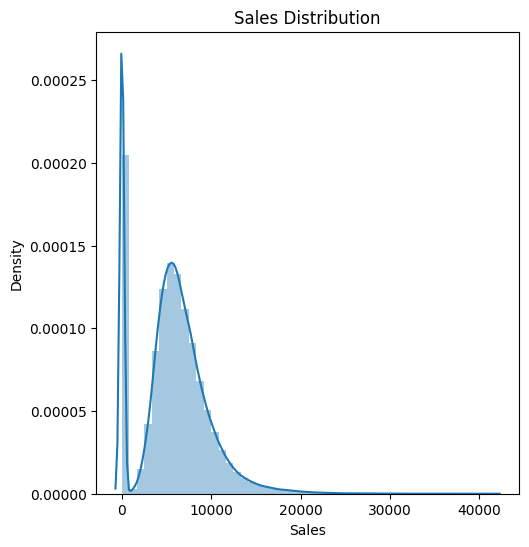

In [ ]:
# Plot sales distribution
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.distplot(df['Sales'])
plt.title('Sales Distribution')

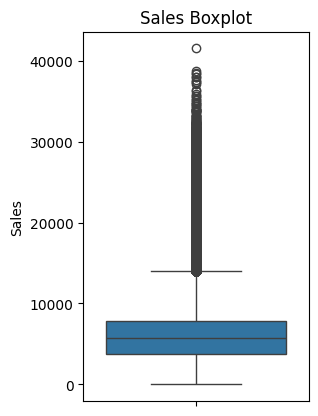

In [ ]:
plt.subplot(1,2,2)
sns.boxplot(df['Sales'])
plt.title('Sales Boxplot')
plt.show()

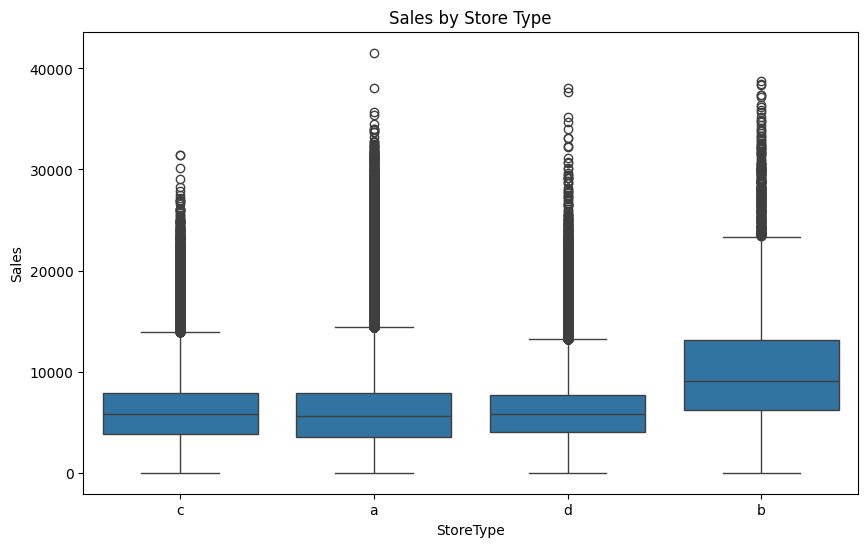

In [ ]:
# Sales by store type
plt.figure(figsize=(10,6))
sns.boxplot(x='StoreType', y='Sales', data=df)
plt.title('Sales by Store Type')
plt.show()

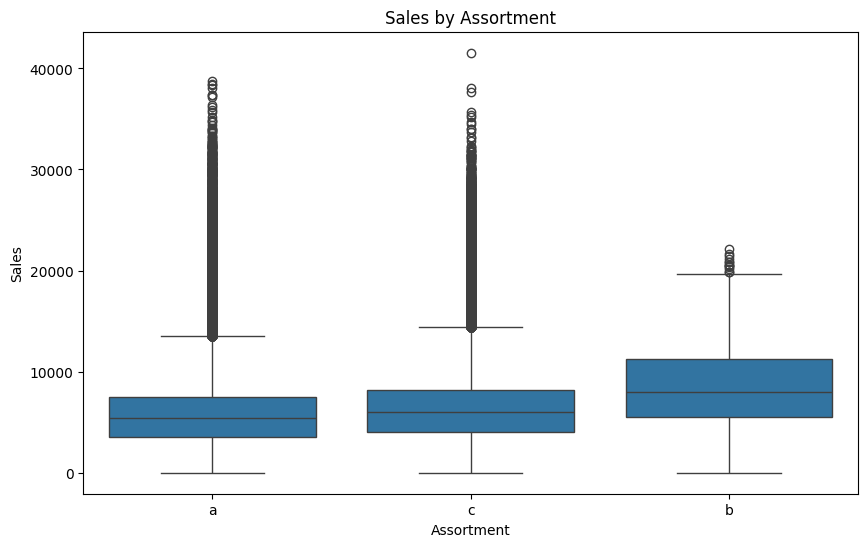

In [ ]:
zzzz

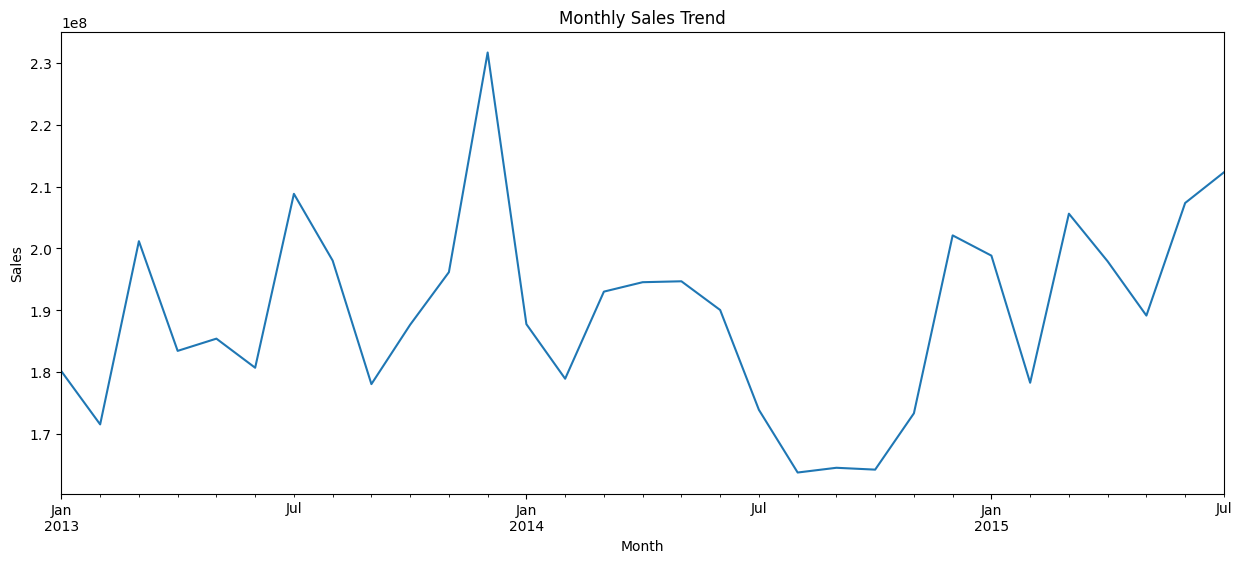

In [ ]:
# Sales over time
df['Date'] = pd.to_datetime(df['Date'])
monthly_sales = df.groupby(df['Date'].dt.to_period('M'))['Sales'].sum()
plt.figure(figsize=(15,6))
monthly_sales.plot()
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.show()

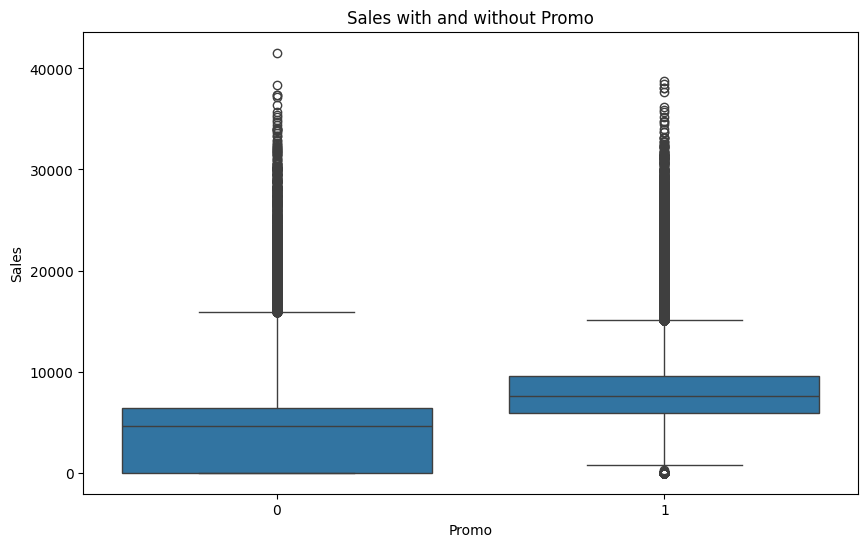

In [ ]:
# Sales by promo
plt.figure(figsize=(10,6))
sns.boxplot(x='Promo', y='Sales', data=df)
plt.title('Sales with and without Promo')
plt.show()

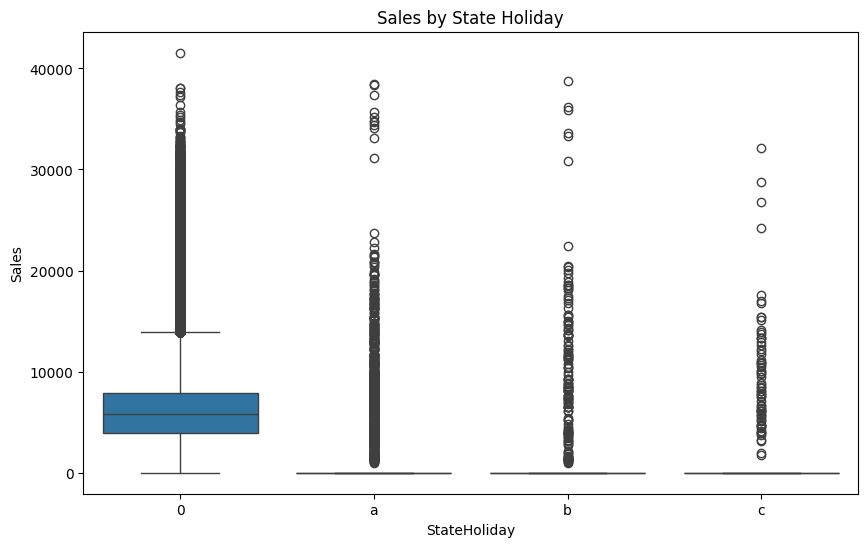

In [ ]:
# Sales by state holiday
plt.figure(figsize=(10,6))
sns.boxplot(x='StateHoliday', y='Sales', data=df)
plt.title('Sales by State Holiday')
plt.show()

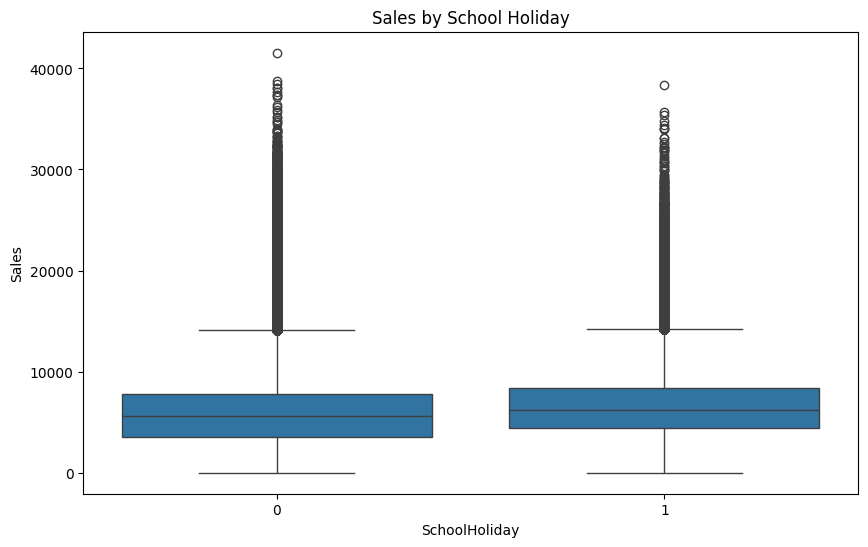

In [ ]:
# Sales by school holiday
plt.figure(figsize=(10,6))
sns.boxplot(x='SchoolHoliday', y='Sales', data=df)
plt.title('Sales by School Holiday')
plt.show()

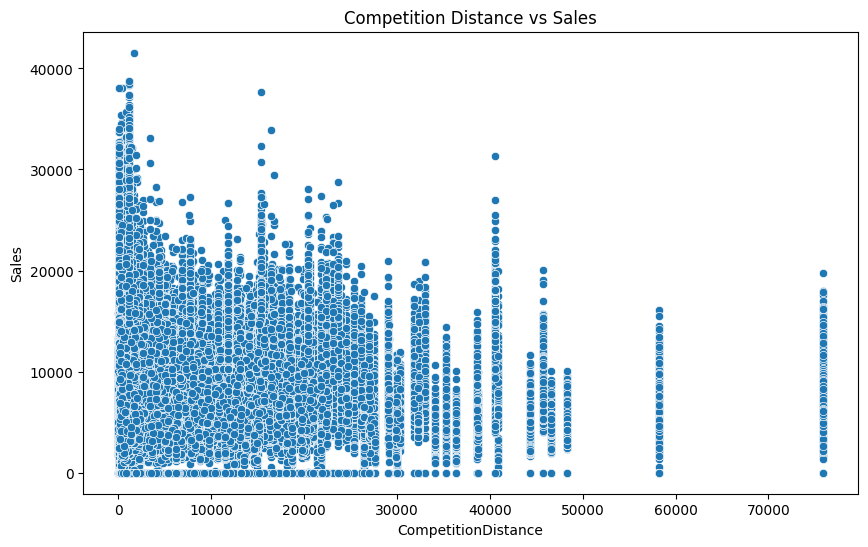

In [ ]:
# Competition distance vs sales
plt.figure(figsize=(10,6))
sns.scatterplot(x='CompetitionDistance', y='Sales', data=df)
plt.title('Competition Distance vs Sales')
plt.show()

##Data Preprocessing

In [ ]:
# Data Preprocessing
# Remove rows where store is closed or sales are 0
df = df[(df['Open'] != 0) & (df['Sales'] > 0)]

# Handle missing values
df['CompetitionDistance'].fillna(df['CompetitionDistance'].median(), inplace=True)
df['CompetitionOpenSinceMonth'].fillna(0, inplace=True)
df['CompetitionOpenSinceYear'].fillna(0, inplace=True)
df['Promo2SinceWeek'].fillna(0, inplace=True)
df['Promo2SinceYear'].fillna(0, inplace=True)
df['PromoInterval'].fillna(0, inplace=True)

# Feature engineering
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['WeekOfYear'] = df['Date'].dt.isocalendar().week
df['CompetitionOpen'] = 12 * (df['Year'] - df['CompetitionOpenSinceYear']) + (df['Month'] - df['CompetitionOpenSinceMonth'])
df['CompetitionOpen'] = df['CompetitionOpen'].clip(lower=0)
df['Promo2Since'] = (df['Year'] - df['Promo2SinceYear']) * 52 + (df['WeekOfYear'] - df['Promo2SinceWeek'])
df['Promo2Since'] = df['Promo2Since'].clip(lower=0).fillna(0)

# Encode categorical variables
le = LabelEncoder()
df['StoreType'] = le.fit_transform(df['StoreType'])
df['Assortment'] = le.fit_transform(df['Assortment'])
df['StateHoliday'] = le.fit_transform(df['StateHoliday'].astype(str))
df['PromoInterval'] = df['PromoInterval'].apply(lambda x: 0 if x == 0 else len([m for m in ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'] if m in str(x)]))

# Drop unnecessary columns
df.drop(['Date', 'Customers', 'Open', 'Promo2SinceWeek', 'Promo2SinceYear', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear'], axis=1, inplace=True)

# Define features and target
X = df.drop(['Sales'], axis=1)
y = df['Sales']

In [ ]:
# Normalize data
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

##Split data into train and test

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Reshape for GRU
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
# Define GRU model
def create_gru_model(units=50, activation='relu', optimizer='adam'):
    model = Sequential()
    model.add(GRU(units, activation=activation, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

# Wrap model with KerasRegressor
model = KerasRegressor(model=create_gru_model, verbose=0)

# Grid search parameters
param_grid = {
    'model__units': [50, 100],
    'model__activation': ['relu', 'tanh'],
    'model__optimizer': ['adam', 'rmsprop'],
    'batch_size': [32, 64],
    'epochs': [30]
}

# Perform GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=1)
grid_result = grid.fit(X_train, y_train)

# Output results
print(f"Best MSE: {-grid_result.best_score_:.4f} using {grid_result.best_params_}")
for mean, std, param in zip(grid_result.cv_results_['mean_test_score'], grid_result.cv_results_['std_test_score'], grid_result.cv_results_['params']):
    print(f"MSE: {-mean:.4f} (±{std:.4f}) with: {param}")

# Evaluate best model
best_model = grid_result.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse:.4f}")

NameError: name 'KerasRegressor' is not defined

##Model Implementation

##GRU Model with Grid Search

In [ ]:

# Mount Google Drive (if using Google Colab)
try:
    from google.colab import drive
    drive.mount('/content/drive')
except ModuleNotFoundError:
    print("Not using Colab, skipping drive mount.")

# Load and merge datasets
train = pd.read_csv('/content/drive/MyDrive/Code implementations/Forecasting in Supply Chain Management/rossmann-store-sales/train.csv')
store = pd.read_csv('/content/drive/MyDrive/Code implementations/Forecasting in Supply Chain Management/rossmann-store-sales/store.csv')
df = pd.merge(train, store, on='Store', how='left')

# Basic EDA
print("Dataset Info:")
print(df.info())
print("\nNull Values:")
print(df.isnull().sum())



AttributeError: 'super' object has no attribute '__sklearn_tags__'